In [1]:
!pip install shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timeit
import shap
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [3]:

df = pd.read_csv("train.csv")
dt = pd.read_csv("test.csv")

# df = pd.read_csv("Vol_Train.csv")
# dt = pd.read_csv("Vol_Test.csv")
df


ID  Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0      3203                          7.3          0.415800             2.4   
1      3204                          7.3          0.415800             2.4   
2      3205                          7.3          0.415800             2.4   
3      3206                          7.3          0.415800             2.4   
4      3207                          7.3          0.415800             2.4   
...     ...                          ...               ...             ...   
9995  13198                         18.3          0.569488             2.0   
9996  13199                         18.3          0.569488             2.0   
9997  13200                         18.3          0.569488             2.0   
9998  13201                         18.3          0.569488             2.0   
9999  13202                         18.3          0.569488             2.0   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0                 5.4              1.0               1.8                0.6   
1                 5.4              1.0               1.8                0.6   
2                 5.4              1.0               1.8                0.6   
3                 5.4              1.0               1.8                0.6   
4                 5.4              1.0               1.8                0.6   
...               ...              ...               ...                ...   
9995              7.2              1.0               0.2                0.4   
9996              7.2              1.0               0.2                0.4   
9997              7.2              1.0               0.2                0.4   
9998              7.2              1.0               0.2                0.4   
9999              7.2              1.0               0.2                0.4   

      Vapour Temperature (K)  Liquid Temperature (K)  ...       Status  \
0                      522.8                   354.3  ...  Superheated   
1                      522.8                   354.3  ...  Superheated   
2                      522.8                   354.3  ...  Superheated   
3                      522.8                   354.3  ...  Superheated   
4                      522.8                   354.3  ...  Superheated   
...                      ...                     ...  ...          ...   
9995                   540.4                   319.1  ...    Subcooled   
9996                   540.4                   319.1  ...    Subcooled   
9997                   540.4                   319.1  ...    Subcooled   
9998                   540.4                   319.1  ...    Subcooled   
9999                   540.4                   319.1  ...    Subcooled   

      Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
0                               37.9                              -1   
1                               37.9                              -1   
2                               37.9                              -1   
3                               37.9                              -1   
4                               37.9                              -1   
...                              ...                             ...   
9995                            37.9                              -1   
9996                            37.9                              -1   
9997                            37.9                              -1   
9998                            37.9                              -1   
9999                            37.9                              -1   

      Liquid Critical Temperature (K)  Sensor ID Sensor Position Side  \
0                               152.0         18                    2   
1                               152.0         19                    3   
2                               152.0         20                    3   
3                               152.0         21                    3   
4   

___

# Check for Mising Values and Duplicates

In [4]:
# Checking missing values
missing_values = df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing, 
     'data type' : df.dtypes
}
check_table = pd.DataFrame(value)
check_table

missing_values   percent_missing % data type
ID                                             0                0.0     int64
Tank Failure Pressure (bar)                    0                0.0   float64
Liquid Ratio (%)                               0                0.0   float64
Tank Width (m)                                 0                0.0   float64
Tank Length (m)                                0                0.0   float64
Tank Height (m)                                0                0.0   float64
BLEVE Height (m)                               0                0.0   float64
Vapour Height (m)                              0                0.0   float64
Vapour Temperature (K)                         0                0.0   float64
Liquid Temperature (K)                         0                0.0   float64
Obstacle Distance to BLEVE (m)                 0                0.0     int64
Obstacle Width (m)                             0                0.0     int64
Obstacle Height (m)                            0                0.0     int64
Obstacle Thickness (m)                         0                0.0   float64
Obstacle Angle                                 0                0.0     int64
Status                                         0                0.0    object
Liquid Critical Pressure (bar)                 0                0.0   float64
Liquid Boiling Temperature (K)                 0                0.0     int64
Liquid Critical Temperature (K)                0                0.0   float64
Sensor ID                                      0                0.0     int64
Sensor Position Side                           0                0.0     int64
Sensor Position x                              0                0.0   float64
Sensor Position y                              0                0.0   float64
Sensor Position z                              0                0.0   float64
Target Pressure (bar)                          0                0.0   float64

In [5]:
print(df.columns)    
print()
print('Number of columns = ', len(df.columns))

Index(['ID', 'Tank Failure Pressure (bar)', 'Liquid Ratio (%)',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

Number of columns =  25


In [6]:
da = df.duplicated(['Target Pressure (bar)', 'Liquid Ratio (%)', 'Sensor Position x'])   # A data-frame with True/False
da.sum()  # = 0 so no duplicated

0

In [7]:
da

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

___

# Feature Selection and Engineeing

In [8]:
# Dropping the following columns since they do not help in prediction

col_to_drop = ["Sensor ID", "ID", 'Liquid Critical Pressure (bar)', 
                'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']
df_1 = df.drop(columns= col_to_drop)
dt_1 = dt.drop(columns= col_to_drop)


In [9]:
df_1

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0                             7.3          0.415800             2.4   
1                             7.3          0.415800             2.4   
2                             7.3          0.415800             2.4   
3                             7.3          0.415800             2.4   
4                             7.3          0.415800             2.4   
...                           ...               ...             ...   
9995                         18.3          0.569488             2.0   
9996                         18.3          0.569488             2.0   
9997                         18.3          0.569488             2.0   
9998                         18.3          0.569488             2.0   
9999                         18.3          0.569488             2.0   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0                 5.4              1.0               1.8                0.6   
1                 5.4              1.0               1.8                0.6   
2                 5.4              1.0               1.8                0.6   
3                 5.4              1.0               1.8                0.6   
4                 5.4              1.0               1.8                0.6   
...               ...              ...               ...                ...   
9995              7.2              1.0               0.2                0.4   
9996              7.2              1.0               0.2                0.4   
9997              7.2              1.0               0.2                0.4   
9998              7.2              1.0               0.2                0.4   
9999              7.2              1.0               0.2                0.4   

      Vapour Temperature (K)  Liquid Temperature (K)  \
0                      522.8                   354.3   
1                      522.8                   354.3   
2                      522.8                   354.3   
3                      522.8                   354.3   
4                      522.8                   354.3   
...                      ...                     ...   
9995                   540.4                   319.1   
9996                   540.4                   319.1   
9997                   540.4                   319.1   
9998                   540.4                   319.1   
9999                   540.4                   319.1   

      Obstacle Distance to BLEVE (m)  Obstacle Width (m)  Obstacle Height (m)  \
0                                 11                  11                   13   
1                                 11                  11                   13   
2                                 11                  11                   13   
3                                 11                  11                   13   
4                                 11                  11                   13   
...                              ...                 ...                  ...   
9995                              14                  12                   15   
9996                              14                  12                   15   
9997                              14                  12                   15   
9998                              14                  12                   15   
9999                              14                  12                   15   

      Obstacle Thickness (m)  Obstacle Angle       Status  \
0                        0.6              13  Superheated   
1                        0.6              13  Superheated   
2                        0.6              13  Superheated   
3                        0.6              13  Superheated   
4                        0.6              13  Superheated   
...                      ...             ...          ...   
9995                     2.2               3    Subcooled   
9996                     2.2               3    Subcooled   
9997     

**One-hot Encoding and Dummy Encoding**

In [10]:
# Label encoding 'Status' feature into 0 and 1 
# 0 for Subcooled and 1 for Superheated

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

df_1['Status'] = LE.fit_transform(df_1['Status'])
dt_1['Status'] = LE.fit_transform(dt_1['Status'])
df_1

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0                             7.3          0.415800             2.4   
1                             7.3          0.415800             2.4   
2                             7.3          0.415800             2.4   
3                             7.3          0.415800             2.4   
4                             7.3          0.415800             2.4   
...                           ...               ...             ...   
9995                         18.3          0.569488             2.0   
9996                         18.3          0.569488             2.0   
9997                         18.3          0.569488             2.0   
9998                         18.3          0.569488             2.0   
9999                         18.3          0.569488             2.0   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0                 5.4              1.0               1.8                0.6   
1                 5.4              1.0               1.8                0.6   
2                 5.4              1.0               1.8                0.6   
3                 5.4              1.0               1.8                0.6   
4                 5.4              1.0               1.8                0.6   
...               ...              ...               ...                ...   
9995              7.2              1.0               0.2                0.4   
9996              7.2              1.0               0.2                0.4   
9997              7.2              1.0               0.2                0.4   
9998              7.2              1.0               0.2                0.4   
9999              7.2              1.0               0.2                0.4   

      Vapour Temperature (K)  Liquid Temperature (K)  \
0                      522.8                   354.3   
1                      522.8                   354.3   
2                      522.8                   354.3   
3                      522.8                   354.3   
4                      522.8                   354.3   
...                      ...                     ...   
9995                   540.4                   319.1   
9996                   540.4                   319.1   
9997                   540.4                   319.1   
9998                   540.4                   319.1   
9999                   540.4                   319.1   

      Obstacle Distance to BLEVE (m)  Obstacle Width (m)  Obstacle Height (m)  \
0                                 11                  11                   13   
1                                 11                  11                   13   
2                                 11                  11                   13   
3                                 11                  11                   13   
4                                 11                  11                   13   
...                              ...                 ...                  ...   
9995                              14                  12                   15   
9996                              14                  12                   15   
9997                              14                  12                   15   
9998                              14                  12                   15   
9999                              14                  12                   15   

      Obstacle Thickness (m)  Obstacle Angle  Status  Sensor Position Side  \
0                        0.6              13       1                     2   
1                        0.6              13       1                     3   
2                        0.6              13       1                     3   
3                        0.6              13       1                     3   
4                        0.6              13       1                     4   
...                      ...             ...     ...                   ...   
9995        

In [11]:
# Dummy Encoding
# If we do not do this, the data may be treated as continuous, which is not true
# For example, in Sensor Position Side, a continuous value of 3 means it is higher than 2 in standard scale.
# However, the true meaning of the value of 3 is that whether that data point has a sensor at that side
# To get this interpretation, we have to dummy encoding

categorical_columns = ['Status', 'Sensor Position Side']

df_2 = pd.get_dummies(data = df_1,                        # dataframe to apply coding
                           prefix_sep='_',                   # 'dummy_'
                           columns = categorical_columns,    # which columns to encode (!!you need to check data information using pandas!!)
                           drop_first =True,                 # drop the original categorical columns 
                           dtype='int8')                     # datatype for the generated columns

dt_2 = pd.get_dummies(data = dt_1,                        # dataframe to apply coding
                           prefix_sep='_',                   # 'dummy_'
                           columns = categorical_columns,    # which columns to encode (!!you need to check data information using pandas!!)
                           drop_first =True,                 # drop the original categorical columns 
                           dtype='int8')                     # datatype for the generated columns

df_2



Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0                             7.3          0.415800             2.4   
1                             7.3          0.415800             2.4   
2                             7.3          0.415800             2.4   
3                             7.3          0.415800             2.4   
4                             7.3          0.415800             2.4   
...                           ...               ...             ...   
9995                         18.3          0.569488             2.0   
9996                         18.3          0.569488             2.0   
9997                         18.3          0.569488             2.0   
9998                         18.3          0.569488             2.0   
9999                         18.3          0.569488             2.0   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0                 5.4              1.0               1.8                0.6   
1                 5.4              1.0               1.8                0.6   
2                 5.4              1.0               1.8                0.6   
3                 5.4              1.0               1.8                0.6   
4                 5.4              1.0               1.8                0.6   
...               ...              ...               ...                ...   
9995              7.2              1.0               0.2                0.4   
9996              7.2              1.0               0.2                0.4   
9997              7.2              1.0               0.2                0.4   
9998              7.2              1.0               0.2                0.4   
9999              7.2              1.0               0.2                0.4   

      Vapour Temperature (K)  Liquid Temperature (K)  \
0                      522.8                   354.3   
1                      522.8                   354.3   
2                      522.8                   354.3   
3                      522.8                   354.3   
4                      522.8                   354.3   
...                      ...                     ...   
9995                   540.4                   319.1   
9996                   540.4                   319.1   
9997                   540.4                   319.1   
9998                   540.4                   319.1   
9999                   540.4                   319.1   

      Obstacle Distance to BLEVE (m)  ...  Obstacle Angle  Sensor Position x  \
0                                 11  ...              13              12.15   
1                                 11  ...              13              12.50   
2                                 11  ...              13              12.50   
3                                 11  ...              13              12.50   
4                                 11  ...              13              12.50   
...                              ...  ...             ...                ...   
9995                              14  ...               3              16.10   
9996                              14  ...               3              16.10   
9997                              14  ...               3              16.10   
9998                              14  ...               3              16.10   
9999                              14  ...               3              16.10   

      Sensor Position y  Sensor Position z  Target Pressure (bar)  Status_1  \
0                  7.90               10.7               0.199929         1   
1                 -2.95               -1.9               0.435681         1   
2                 -2.95                4.4               0.264031         1   
3                 -2.95               10.7               0.270576         1   
4                 -2.70               11.0               0.204675         1   
...                 ...                ...                    ...       ...   
9995             

In [12]:
df_2.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)',
       'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)',
       'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)',
       'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Obstacle Angle',
       'Sensor Position x', 'Sensor Position y', 'Sensor Position z',
       'Target Pressure (bar)', 'Status_1', 'Sensor Position Side_2',
       'Sensor Position Side_3', 'Sensor Position Side_4',
       'Sensor Position Side_5'],
      dtype='object')

**Creating extra feature and Re-ordering columns**

In [13]:
# Creating a new feature "Tank Volume (m3)"

df_2['Tank Volume (m3)'] = df_2['Tank Width (m)'] * df_2['Tank Length (m)'] * df_2['Tank Height (m)']
dt_2['Tank Volume (m3)'] = dt_2['Tank Width (m)'] * dt_2['Tank Length (m)'] * dt_2['Tank Height (m)']

df_2.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)',
       'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)',
       'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)',
       'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Obstacle Angle',
       'Sensor Position x', 'Sensor Position y', 'Sensor Position z',
       'Target Pressure (bar)', 'Status_1', 'Sensor Position Side_2',
       'Sensor Position Side_3', 'Sensor Position Side_4',
       'Sensor Position Side_5', 'Tank Volume (m3)'],
      dtype='object')

In [14]:
# Re-ordering the columns

cols_train= list(df_2.columns)
cols_test= list(dt_2.columns)

df_3 = df_2[cols_train[0:5] + [cols_train[-1]] + cols_train[5:-1]]
dt_3 = dt_2[cols_test[0:5] + [cols_test[-1]] + cols_test[5:-1]]

df_3.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'Tank Volume (m3)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Sensor Position x', 'Sensor Position y',
       'Sensor Position z', 'Target Pressure (bar)', 'Status_1',
       'Sensor Position Side_2', 'Sensor Position Side_3',
       'Sensor Position Side_4', 'Sensor Position Side_5'],
      dtype='object')

In [15]:
# Moving 'Target Pressure (bar)' to the last column

df_target = df_3['Target Pressure (bar)']
df_4 = df_3.drop(columns='Target Pressure (bar)')
df_4 = pd.concat([df_4, df_target], axis=1)
df_4

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0                             7.3          0.415800             2.4   
1                             7.3          0.415800             2.4   
2                             7.3          0.415800             2.4   
3                             7.3          0.415800             2.4   
4                             7.3          0.415800             2.4   
...                           ...               ...             ...   
9995                         18.3          0.569488             2.0   
9996                         18.3          0.569488             2.0   
9997                         18.3          0.569488             2.0   
9998                         18.3          0.569488             2.0   
9999                         18.3          0.569488             2.0   

      Tank Length (m)  Tank Height (m)  Tank Volume (m3)  BLEVE Height (m)  \
0                 5.4              1.0             12.96               1.8   
1                 5.4              1.0             12.96               1.8   
2                 5.4              1.0             12.96               1.8   
3                 5.4              1.0             12.96               1.8   
4                 5.4              1.0             12.96               1.8   
...               ...              ...               ...               ...   
9995              7.2              1.0             14.40               0.2   
9996              7.2              1.0             14.40               0.2   
9997              7.2              1.0             14.40               0.2   
9998              7.2              1.0             14.40               0.2   
9999              7.2              1.0             14.40               0.2   

      Vapour Height (m)  Vapour Temperature (K)  Liquid Temperature (K)  ...  \
0                   0.6                   522.8                   354.3  ...   
1                   0.6                   522.8                   354.3  ...   
2                   0.6                   522.8                   354.3  ...   
3                   0.6                   522.8                   354.3  ...   
4                   0.6                   522.8                   354.3  ...   
...                 ...                     ...                     ...  ...   
9995                0.4                   540.4                   319.1  ...   
9996                0.4                   540.4                   319.1  ...   
9997                0.4                   540.4                   319.1  ...   
9998                0.4                   540.4                   319.1  ...   
9999                0.4                   540.4                   319.1  ...   

      Obstacle Angle  Sensor Position x  Sensor Position y  Sensor Position z  \
0                 13              12.15               7.90               10.7   
1                 13              12.50              -2.95               -1.9   
2                 13              12.50              -2.95                4.4   
3                 13              12.50              -2.95               10.7   
4                 13              12.50              -2.70               11.0   
...              ...                ...                ...                ...   
9995               3              16.10               0.80               14.7   
9996               3              16.10               6.60               14.7   
9997               3              16.10               6.85               -0.2   
9998               3              16.10               6.85                7.1   
9999               3              16.10               6.85               14.4   

      Status_1  Sensor Position Side_2  Sensor Position Side_3  \
0            1                       1                       0   
1            1                       0                       1   
2            1                       0                       1   
3            1    

In [16]:
# Save to csv
df_4.to_csv('Final_Train.csv', index=False)
dt_3.to_csv('Final_Test.csv', index=False)

In [17]:
# Re-load 
df = pd.read_csv("Final_Train.csv")
dt = pd.read_csv("Final_Test.csv")
df

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0                             7.3          0.415800             2.4   
1                             7.3          0.415800             2.4   
2                             7.3          0.415800             2.4   
3                             7.3          0.415800             2.4   
4                             7.3          0.415800             2.4   
...                           ...               ...             ...   
9995                         18.3          0.569488             2.0   
9996                         18.3          0.569488             2.0   
9997                         18.3          0.569488             2.0   
9998                         18.3          0.569488             2.0   
9999                         18.3          0.569488             2.0   

      Tank Length (m)  Tank Height (m)  Tank Volume (m3)  BLEVE Height (m)  \
0                 5.4              1.0             12.96               1.8   
1                 5.4              1.0             12.96               1.8   
2                 5.4              1.0             12.96               1.8   
3                 5.4              1.0             12.96               1.8   
4                 5.4              1.0             12.96               1.8   
...               ...              ...               ...               ...   
9995              7.2              1.0             14.40               0.2   
9996              7.2              1.0             14.40               0.2   
9997              7.2              1.0             14.40               0.2   
9998              7.2              1.0             14.40               0.2   
9999              7.2              1.0             14.40               0.2   

      Vapour Height (m)  Vapour Temperature (K)  Liquid Temperature (K)  ...  \
0                   0.6                   522.8                   354.3  ...   
1                   0.6                   522.8                   354.3  ...   
2                   0.6                   522.8                   354.3  ...   
3                   0.6                   522.8                   354.3  ...   
4                   0.6                   522.8                   354.3  ...   
...                 ...                     ...                     ...  ...   
9995                0.4                   540.4                   319.1  ...   
9996                0.4                   540.4                   319.1  ...   
9997                0.4                   540.4                   319.1  ...   
9998                0.4                   540.4                   319.1  ...   
9999                0.4                   540.4                   319.1  ...   

      Obstacle Angle  Sensor Position x  Sensor Position y  Sensor Position z  \
0                 13              12.15               7.90               10.7   
1                 13              12.50              -2.95               -1.9   
2                 13              12.50              -2.95                4.4   
3                 13              12.50              -2.95               10.7   
4                 13              12.50              -2.70               11.0   
...              ...                ...                ...                ...   
9995               3              16.10               0.80               14.7   
9996               3              16.10               6.60               14.7   
9997               3              16.10               6.85               -0.2   
9998               3              16.10               6.85                7.1   
9999               3              16.10               6.85               14.4   

      Status_1  Sensor Position Side_2  Sensor Position Side_3  \
0            1                       1                       0   
1            1                       0                       1   
2            1                       0                       1   
3            1    

___

# 

# Correlation

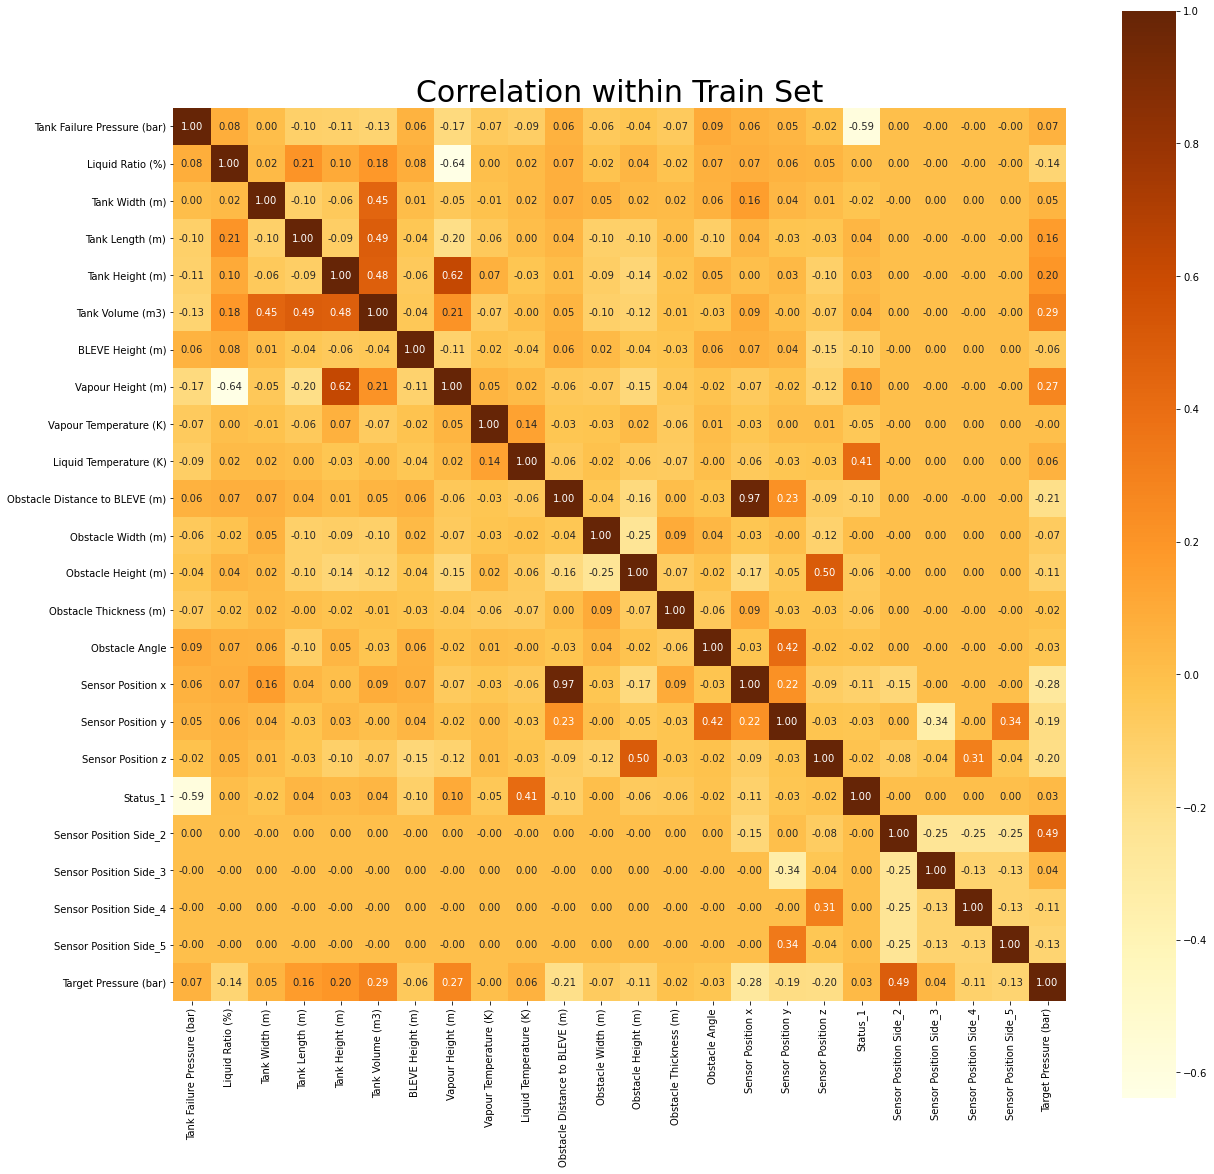

In [18]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f', cmap = "YlOrBr")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
plt.title('Correlation within Train Set', fontsize = 30)
plt.show()

# Train-Test set splitting

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = df.drop('Target Pressure (bar)', axis=1)
y = df['Target Pressure (bar)']
X_Kaggle = dt

X_traindf, X_testdf, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_traindf.shape)
print(X_testdf.shape)

(7500, 23)
(2500, 23)


In [21]:
y_test 

6252    0.087878
4684    0.085003
1731    0.230743
4742    0.070305
4521    0.089359
          ...   
4862    0.769194
7025    0.217490
7647    0.117789
7161    0.081134
73      0.624510
Name: Target Pressure (bar), Length: 2500, dtype: float64

# Standardization and Power Transform

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>],
       [<AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'19'}>],
       [<AxesSubplot:title={'center':'20'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSub

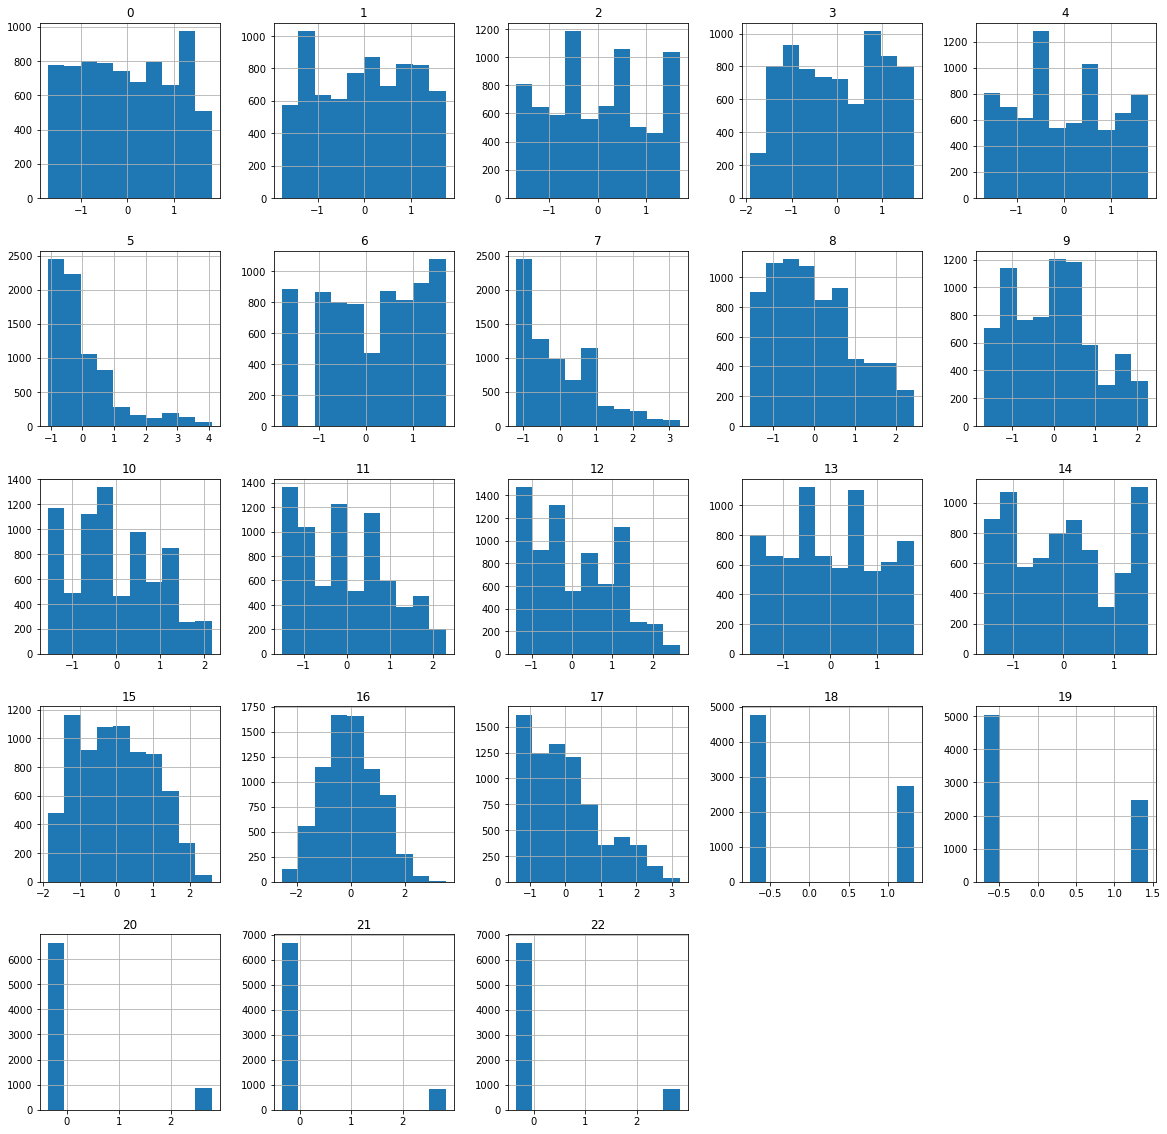

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# Processing both X_train and X_test using standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_traindf)
X_test = scaler.transform(X_testdf)
X_Kaggle = scaler.transform(X_Kaggle)

# Double check if it succeeded
df_stdscal = pd.DataFrame(X_train)
df_stdscal.hist(figsize = (20,20), bins=10)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


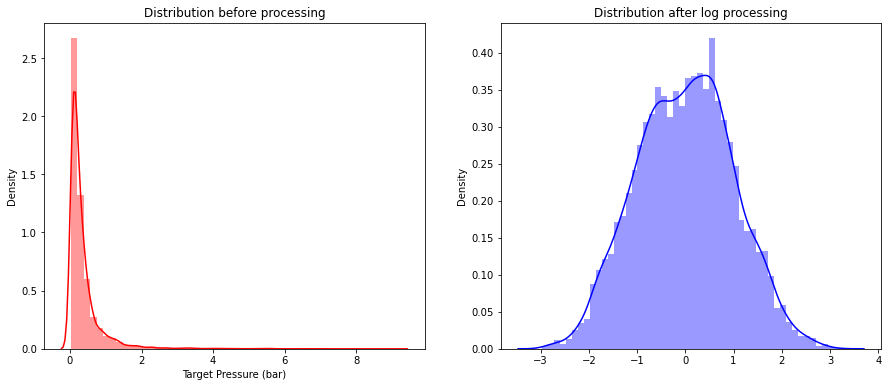

In [23]:
y_train2D = y_train.values.reshape(-1,1)
y_test2D = y_test.values.reshape(-1,1)

power = PowerTransformer(method='box-cox')

y_train_normal = power.fit_transform(y_train2D)
y_test_normal = power.transform(y_test2D)

# Visualize the effect of power transformation
f = plt.figure(figsize=(15, 6))

ax = f.add_subplot(121)
sns.distplot(y_train, bins=50, color='r', ax=ax)
ax.set_title('Distribution before processing')

ax=f.add_subplot(122)
sns.distplot(y_train_normal, bins=50, color='b', ax=ax)
ax.set_title('Distribution after log processing')
print()

___

# ANN - Developing my best model using PyTorch

In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.backends.cudnn.version() , torch.backends.cudnn.enabled

(8200, True)

In [25]:
# convert data to torch.FloatTensor
X_train_torch = torch.from_numpy(X_train.astype(np.float32))
X_test_torch = torch.from_numpy(X_test.astype(np.float32))
y_train_torch = torch.from_numpy(y_train_normal.astype(np.float32).reshape(-1, 1))
y_test_torch = torch.from_numpy(y_test_normal.astype(np.float32).reshape(-1, 1))

X_train_torch

tensor([[ 0.1798,  1.2494,  1.4400,  ..., -0.3592, -0.3523, -0.3525],
        [-0.1922, -0.3257, -0.9132,  ...,  2.7841, -0.3523, -0.3525],
        [-1.6803,  1.4283,  0.9171,  ...,  2.7841, -0.3523, -0.3525],
        ...,
        [-1.0984,  1.1709, -1.6976,  ..., -0.3592, -0.3523, -0.3525],
        [ 1.4771,  0.8920,  0.3941,  ..., -0.3592, -0.3523, -0.3525],
        [ 0.8571,  0.4068,  1.4400,  ..., -0.3592, -0.3523,  2.8367]])

In [26]:
train_data = []
for i in range(len(X_train_torch)):
   train_data.append([X_train_torch[i], y_train_torch[i]])

test_data = []
for i in range(len(X_test_torch)):
   test_data.append([X_test_torch[i], y_test_torch[i]])


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512,
    num_workers=6)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512,
    num_workers=6)


In [27]:
## Define the NN architecture
## NN with 3 hidden layer, s=[26, 256, 256, 256, 1]

class BleveNet(nn.Module):
    def __init__(self):
        super(BleveNet, self).__init__()
        # The first hidden layer has 256 neurons
        self.fc1 = nn.Linear(X_train_torch.shape[1], 256)
        # The second hidden layer has 256 neurons
        self.fc2 = nn.Linear(256, 256)
        # The third hidden layer has 256 neurons
        self.fc3 = nn.Linear(256, 256)
        # The final layer has 1 output neuron
        self.fc4 = nn.Linear(256, 1)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.1)

        # Mish activation
        self.mish = nn.Mish()


    def forward(self, x):
        # add first fully connected layer
        x = self.fc1(x)
        x = self.mish(x)
        x = self.dropout(x)
        # add second fully connected layer
        x = self.fc2(x)
        x = self.mish(x)
        x = self.dropout(x)
        # add third fully connected layer
        x = self.fc3(x)
        x = self.mish(x)
        x = self.dropout(x)
        # add final fully connected layer
        x = self.fc4(x)
        return x

# initialize the NN
model = BleveNet()
print(model)

BleveNet(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (mish): Mish()
)


In [28]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.HuberLoss()        # This is the best loss function for my model     

#criterion = nn.L1Loss() 
#criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()




# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)     # This is the best optimizer for my model 

#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)

In [29]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Train the model  -- Do not need to rerun this cell. I already trained, saved and included the model state to load below**


In [30]:
# n_epochs = 200 

# model.train()       # prep model for training
# model.to(device)    # bring the model to gpu
# train_losses = []
# for epoch in range(n_epochs):
#     # monitor training loss
#     train_loss = 0.0
    
#     ###################
#     # train the model #
#     ###################
#     for data, target in train_loader:
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         #bring data and target to gpu
#         data, target = data.to(device), target.to(device)
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the loss
#         loss = criterion(output, target)
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()
#         # update running training loss
#         train_loss += loss.item()*data.size(0)
        
#     # print training statistics 
#     # calculate average loss over an epoch
#     train_loss = train_loss/len(train_loader.dataset)
#     train_losses.append(train_loss)

#     print('Epoch: {}/{} \tTraining Loss: {:.6f}'.format(
#         epoch+1,
#         n_epochs, 
#         train_loss
#         ))

In [31]:
# plt.plot(train_losses)

# Save the model  -- I already saved this and submitted
# torch.save(model.state_dict(), 'PyTorch_model/NN_mish_Drop_L2_Huber_200Epoch_Vol.pt')

**Loading the saved state**

In [32]:
model.load_state_dict(torch.load('NN_mish_Drop_L2_Huber_200Epoch_Vol.pt', map_location=torch.device('cpu')))

model.eval()           # prep model for *evaluation*
model.to(device)
with torch.no_grad():  # turn off gradient to save memory
    y_predNN_torch = model(X_test_torch.to(device))

y_predNN_normal = y_predNN_torch.cpu().numpy()     # convert to numpy array
y_predNN_normal

array([[-1.1719232 ],
       [-0.9226208 ],
       [ 0.09030131],
       ...,
       [-0.32790422],
       [-0.82843024],
       [ 1.0767128 ]], dtype=float32)

In [33]:
mape = mean_absolute_percentage_error(y_test_normal, y_predNN_normal)
r2 = r2_score(y_test_normal, y_predNN_normal)
print(f"Neural Network scores in normal distribution: r2 = {r2}, mape = {mape}")

Neural Network scores in normal distribution: r2 = 0.981727006946242, mape = 1.2394187994223216


The MAPE in normal distribution seems quite high. However, inverse_transform the predictions back to its actual distribution delivers very good MAPE

In [34]:
y_predNN = power.inverse_transform(y_predNN_normal)
mape = mean_absolute_percentage_error(y_test.values, y_predNN.flatten())
r2 = r2_score(y_test, y_predNN)

print(f"Neural Network scores in actual distribution: r2 = {r2}, mape = {mape}")

Neural Network scores in actual distribution: r2 = 0.9760887655119213, mape = 0.0982265057606872


**Predicting the Test set and save to csv**

In [35]:
X_Kaggle_torch = torch.from_numpy(X_Kaggle.astype(np.float32))
model.eval()           # prep model for *evaluation*
model.to(device)
with torch.no_grad():  # turn off gradient to save memory
    y_KaggleNN_torch = model(X_Kaggle_torch.to(device))

y_KaggleNN_normal = y_KaggleNN_torch.cpu().numpy()     # convert to numpy array
y_KaggleNN = power.inverse_transform(y_KaggleNN_normal)



ID = np.arange(0,3203)
y_nn = np.concatenate([ID.reshape(-1,1), y_KaggleNN], axis = 1, dtype=object)
answers_nn = pd.DataFrame(y_nn, columns = ['ID', 'Target Pressure (bar)'])
#answers_nn.to_csv('NN_predict8_mish_Drop_L2_Huber_200Epoch_Vol.csv', index=False)

answers_nn.head(10)    # This gives MAPE = 18.15216 on Kaggle

ID Target Pressure (bar)
0  0              0.247545
1  1              0.268898
2  2              0.370549
3  3              0.407609
4  4               0.30236
5  5              0.203456
6  6              0.180585
7  7              0.180552
8  8              0.327818
9  9               1.75667

However, PyTorch model is not compatible with Explainable Library. I had to re-develop the above model using Scikit-Learn with some adjustments. These adjustments **increases** the MAPE by 4% on the **test set** compared to the above model.
+ No Drop-out since Scikit-Learn do not have this argument
+ Replacing Mish activation function with Tanh

# Re-developing ANN using Sci-kit Learn

In [36]:
from sklearn.neural_network import MLPRegressor

In [37]:
# Train the model  -- Do not need to rerun this cell. 
# I already trained, saved and included the model state to load below**

BleveNet = MLPRegressor(hidden_layer_sizes=(256,256,256), activation='tanh', solver='adam',
                        alpha=1e-5, learning_rate_init=0.005, batch_size=512, n_iter_no_change=100,
                        random_state=42)

# BleveNet.fit(X_train, y_train_normal.flatten())

In [38]:
# Save the model

import pickle

filename = 'NN.sav'
#pickle.dump(BleveNet, open(filename, 'wb'))

In [39]:
# load the model from disk
BleveNet = pickle.load(open(filename, 'rb'))

# Inference/Predict on test data
y_pred_normal = BleveNet.predict(X_test)

# Evaluate the regression performance using r2 and mape
r2 = r2_score(y_test_normal, y_pred_normal)
mape = mean_absolute_percentage_error(y_test_normal, y_pred_normal)
print(f"Neural Network Scores in normal distribution: r2 = {r2}, mape = {mape}")


y_pred = power.inverse_transform(y_pred_normal.reshape(-1,1))
# Evaluate the regression performance using r2 and mape
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred.flatten())
print(f"Neural Network Scores in actual distribution: r2 = {r2}, mape = {mape}")

Neural Network Scores in normal distribution: r2 = 0.9782242278425588, mape = 0.9072299496112682
Neural Network Scores in actual distribution: r2 = 0.9727994521700514, mape = 0.10535784689055601


**Predicting the Test set and save to csv**

In [40]:
y_KaggleNN_normal = BleveNet.predict(X_Kaggle)
y_KaggleNN = power.inverse_transform(y_KaggleNN_normal.reshape(-1,1))


ID = np.arange(0,3203)
y_nn = np.concatenate([ID.reshape(-1,1), y_KaggleNN], axis = 1, dtype=object)
answers_nn = pd.DataFrame(y_nn, columns = ['ID', 'Target Pressure (bar)'])
#answers_nn.to_csv(NN_predict20_tanh_NoDrop_L2_MSE_100Epoch_Vol.csv', index=False)

answers_nn.head(20)   # This gives MAPE = 22.22229 on Kaggle


ID Target Pressure (bar)
0    0              0.217698
1    1              0.261688
2    2              0.389886
3    3              0.318009
4    4              0.243112
5    5              0.183538
6    6              0.118232
7    7              0.177295
8    8              0.278542
9    9              1.598045
10  10              1.505379
11  11               1.56666
12  12              3.007661
13  13              2.744362
14  14              2.577332
15  15              1.408563
16  16              1.532639
17  17              1.372627
18  18              0.637634
19  19              0.685676

We will use this model to perform Interpretation

___

# Partial Dependency Plot

In [41]:
X.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'Tank Volume (m3)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Sensor Position x', 'Sensor Position y',
       'Sensor Position z', 'Status_1', 'Sensor Position Side_2',
       'Sensor Position Side_3', 'Sensor Position Side_4',
       'Sensor Position Side_5'],
      dtype='object')

In [42]:
X.columns.get_loc('Sensor Position Side_3') , X.columns.get_loc('Sensor Position y'), X.columns.get_loc('Sensor Position Side_2'), X.columns.get_loc('Sensor Position x'), X.columns.get_loc('Vapour Height (m)')


(20, 16, 19, 15, 7)

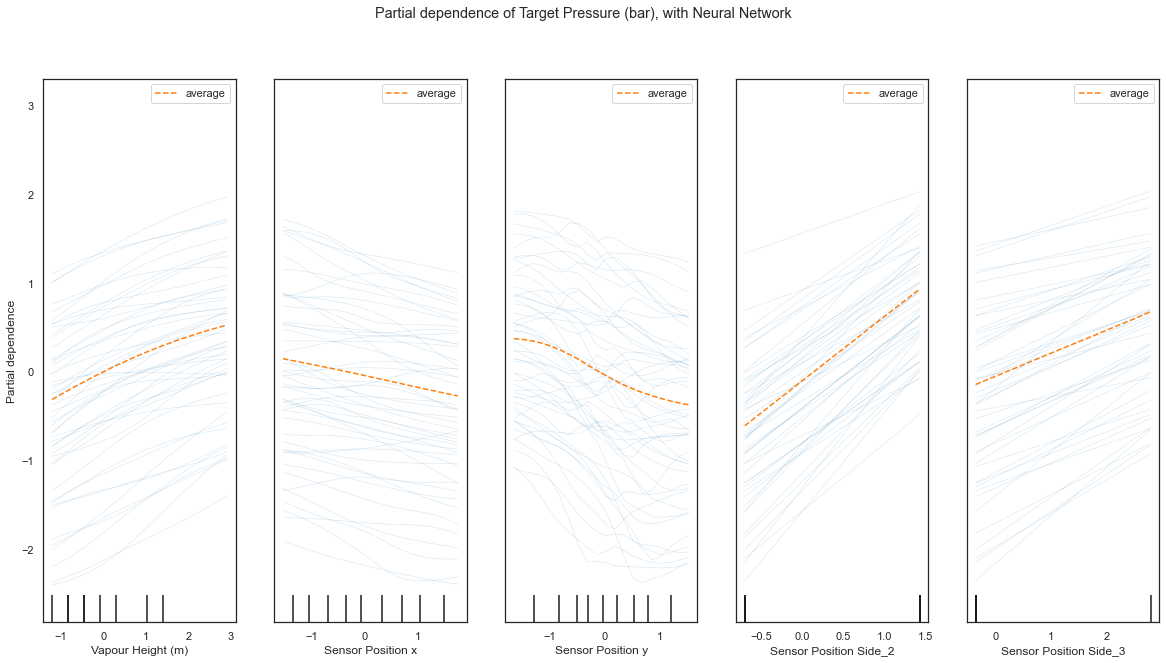

In [43]:
from sklearn.inspection import PartialDependenceDisplay

sns.set_theme(style="white")
pdp = PartialDependenceDisplay

features = [7, 15, 16, 19, 20]


fig, ax = plt.subplots(figsize=(20, 10))

display = pdp.from_estimator(BleveNet, X_Kaggle, features, kind="both",
                    subsample=50,
                    n_jobs=6,
                    n_cols=6,
                    grid_resolution=20,
                    random_state=0,
                    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
                    feature_names = X.columns,
                    ax = ax
                    )


display.figure_.suptitle("Partial dependence of Target Pressure (bar), with Neural Network")
display.figure_.subplots_adjust(hspace=0.5)

+ **Higher** Vapor Height will lead to **higher** Target Pressure.
+ If a data point has a sensor at wall side '2', it will have **higher** Target Pressure.
+ If a data point has a sensor at wall side '3', it will have **higher** Target Pressure.
+ **Higher** coordinate in Sensor Position x will lead to **lower** Target Pressure.
+ **Higher** coordinate in Sensor Position y will lead to **lower** Target Pressure.

___

# Global Intepretation with Shap

In [44]:
# DO NOT compute the shap values, it took 16 hours to run in my laptop
# I already saved the values and submitted so that you can reload

explainer = shap.KernelExplainer(BleveNet.predict, shap.kmeans(X_train, 200))
# shap_values = explainer.shap_values(X_train)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [45]:
from numpy import asarray
from numpy import save

# save to npy file
# save('NNshap_new.npy', shap_values)

In [46]:
from numpy import load
# load array
shap_values = load('NNshap_train.npy')
# print the array
shap_values

array([[ 0.09418566, -0.01034791,  0.16919778, ..., -0.09150124,
        -0.05530267, -0.0815583 ],
       [-0.01360362,  0.03412043, -0.11305322, ...,  0.85629685,
        -0.05297153, -0.06022313],
       [-0.61835036, -0.01524331,  0.08590786, ...,  0.82733333,
        -0.0509509 , -0.05710309],
       ...,
       [-0.32634772,  0.02747647, -0.20300897, ..., -0.10139961,
        -0.04668787, -0.0727947 ],
       [ 0.20118067, -0.0338848 ,  0.04979384, ..., -0.0683755 ,
        -0.04258572, -0.05943833],
       [ 0.16268929, -0.02695029,  0.05414897, ..., -0.08112963,
        -0.05454918,  0.74295694]])

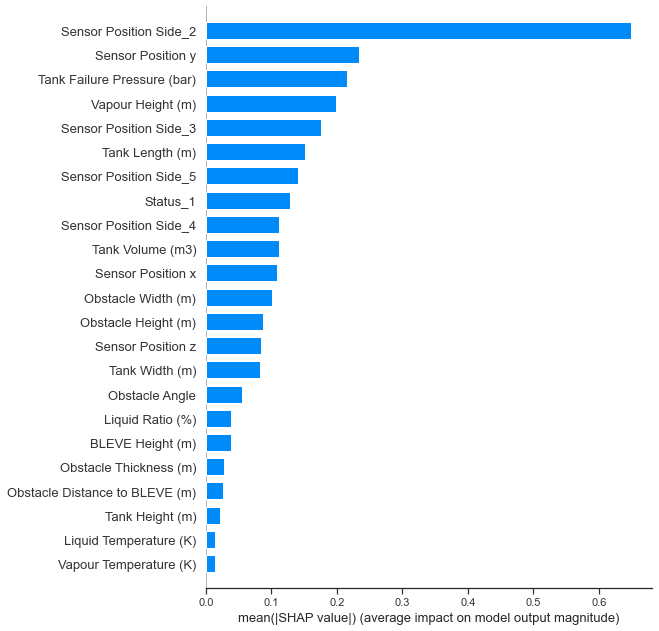

In [47]:
# Feature Importance Plot
shap.summary_plot(shap_values, X_Kaggle, plot_type="bar", feature_names=X.columns, max_display = 23)

Based on the calculation of average impact, the feature importances decrease from top to bottom:
+ Sensor Position Side_2 has the most significant impact on the Target Pressure
+ Vapour Temperature (K) has the least impact on the Target Pressure

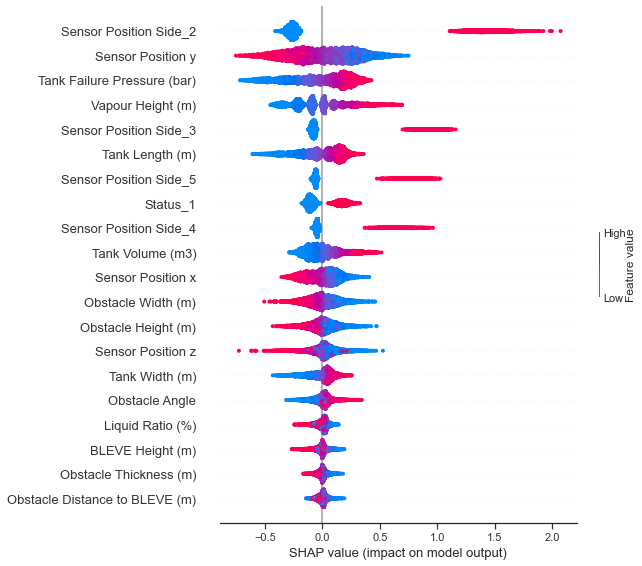

In [48]:
# Feature Effect Plot
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

+ High feature values are in red

+ Low feature values are in blue

+ For Sensor Position Side_2, **higher** feature value (the data point has a sensor at wall side '2') will result in **higher** Shap Value which contributes positively to the prediction (Higher Target Pressure) and vice versa.

+ For Sensor Position y, **higher** feature value (higher coordinate in Sensor Position y) will result in **lower** Shap Value which contributes negatively to the prediction (Lower Target Pressure) and vice versa.

+ Feature importances decrease from top to bottom.


In [49]:
X.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'Tank Volume (m3)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Sensor Position x', 'Sensor Position y',
       'Sensor Position z', 'Status_1', 'Sensor Position Side_2',
       'Sensor Position Side_3', 'Sensor Position Side_4',
       'Sensor Position Side_5'],
      dtype='object')

# Feature Interaction Plot

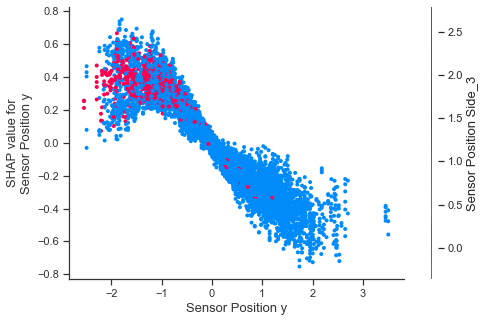

In [50]:
shap.dependence_plot('Sensor Position y', shap_values, X_train, feature_names=X.columns, interaction_index='Sensor Position Side_3')

+ Having Sensor Position at wall side '3' with **low** Sensor Position y almost guarantees a **high** Target Pressure (with a few outliers)
+ However, this does not translate to the opposite case.
+ Not having Sensor Position at wall side '3' does not help Sensor Position y in predicting Target Pressure. The blue feature values scatter all around the map

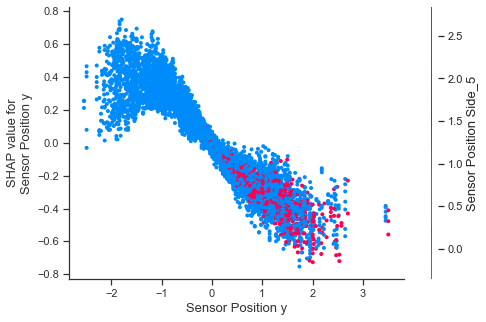

In [51]:
shap.dependence_plot('Sensor Position y', shap_values, X_train, feature_names=X.columns, interaction_index='Sensor Position Side_5')

+ Having Sensor Position at wall side '5' with **high** Sensor Position y almost guarantee a **low** Target Pressure (with a few outliers)
+ However, this does not translate to the opposite case.
+ Not having Sensor Position at wall side '5' does not help Sensor Position y in predicting Target Pressure. The blue feature values scatter all around the map

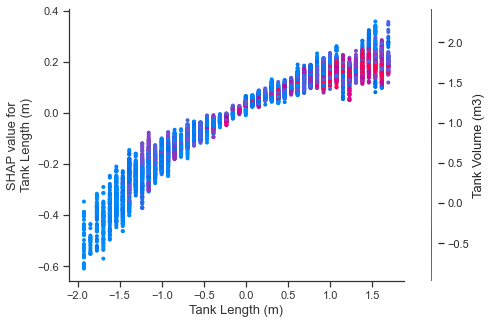

In [52]:
shap.dependence_plot('Tank Length (m)', shap_values, X_train, feature_names=X.columns, interaction_index='Tank Volume (m3)')

+ Since Tank Length (m) was used to compute Tank Volume (m3), they have high linear correlation to each other
+ **Moderate to high** Tank Volume with **high** Tank Length will result in higher Target Pressure (with a few outliers)
+ **Low** Tank Volume and **low** Tank Length will cause lower Target Pressure

In [53]:
X.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'Tank Volume (m3)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Sensor Position x', 'Sensor Position y',
       'Sensor Position z', 'Status_1', 'Sensor Position Side_2',
       'Sensor Position Side_3', 'Sensor Position Side_4',
       'Sensor Position Side_5'],
      dtype='object')

___

# Lime

In [54]:
!pip install lime
import lime
import lime.lime_tabular

___

# Local Intepretation

In [55]:
y_predTrain_normal = BleveNet.predict(X_train)
y_predTrain_normal
y_predTrain = power.inverse_transform(y_predTrain_normal.reshape(-1,1))
# Evaluate the regression performance using r2 and mape
r2 = r2_score(y_train, y_predTrain)
mape = mean_absolute_percentage_error(y_train, y_predTrain.flatten())
print(f"Neural Network Scores:, r2 = {r2}, mape = {mape}")

Neural Network Scores:, r2 = 0.9958102062296317, mape = 0.03629399405663303


# Lowest Prediction

In [56]:
np.argmin(y_predTrain), y_predTrain_normal[4176], y_predTrain[4176][0]

(4176, -2.9011460450055333, 0.016853437790202826)

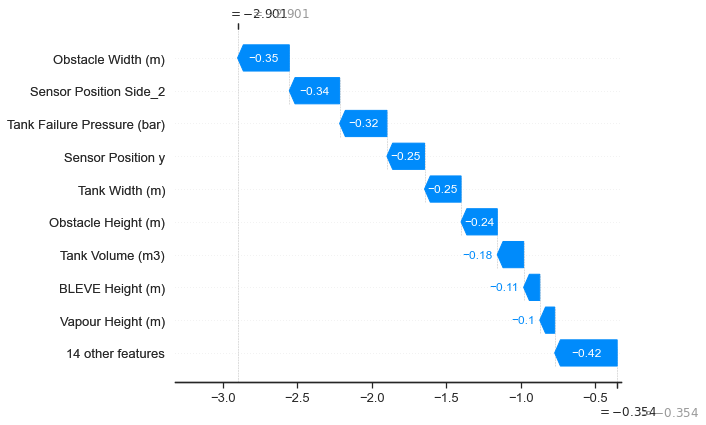

In [57]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[4176], feature_names = X.columns)

In [58]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4176], features = X.columns)

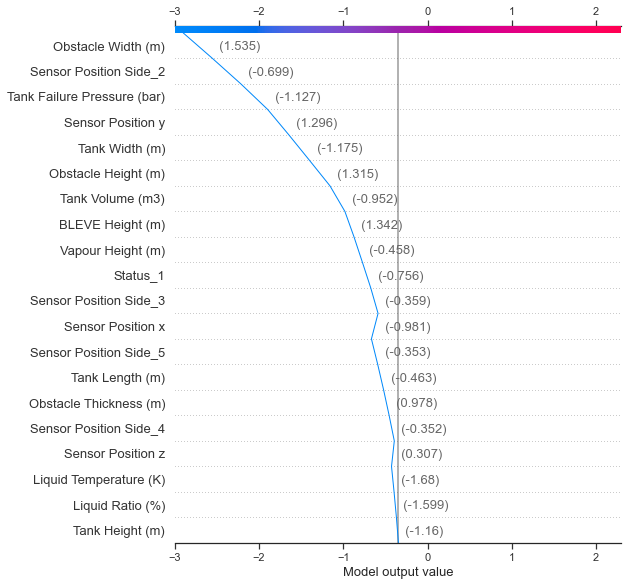

In [59]:
shap.decision_plot(explainer.expected_value, shap_values[4176], 
                   features = X_train[4176], feature_names = X.columns.tolist())

Almost all features which have the most impact on the model contribute negatively to this prediction, such as:
+ Sensor Position Side_2     ----  (No sensor at this wall side)
+ Sensor Position y          ----  (High coordinate at y-position)
+ Tank Failure Pressure (bar) ---- (Low Tank Failure Pressure)
+ Vapor Height (m) and so on  ---- (Low Vapor Height)


Only 3 features contribute positively which are: 
+ Vapour Temperature (K) ---- (Moderate-to-low vapour Temperature)
+ Sensor Position z      ---- (Low coordinate at z-position)
+ Sensor Position x      ---- (Low coordinate at x-position)

Except for Sensor Position x which has moderate impact shown in the Shap summary plot, the other 2 features are insignificant.

Although only being moderate in the Shap summary plot, Obstacle Width (m) has the most impact in this prediction --- High Obstacle Width (m)

In [60]:
# instance id to be explained
i = 4176
# LIME API works with numpy array
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Target Pressure (bar)'], 
                                                        verbose=True, mode='regression', kernel_width=0.75*len(X.columns), random_state=42)

exp = lime_explainer.explain_instance(X_train[i], BleveNet.predict, num_features=22)

exp.show_in_notebook(show_table=True)

Intercept 3.231182297055727
Prediction_local [-0.95196771]
Right: -2.9011460450055333


Although the Prediction_local is not close to the actual prediction (-2.90114), Lime still does a very good job in explaining why this data point is the minimum: 
+ Lime says that significant features such as Sensor Position Side_2, 3, 4, 5, y, Tank Failure Pressure, etc. contribute negatively to this prediction.

+ Lime has 6 features contributing positively to this prediction. However, similar to Shap, apart from Sensor Position x which is moderate, the others are insignificant

# Highest Prediction

In [61]:
np.argmax(y_predTrain), y_predTrain_normal[5499], y_predTrain[5499][0]

(5499, 3.1212327192833302, 8.186150098076817)

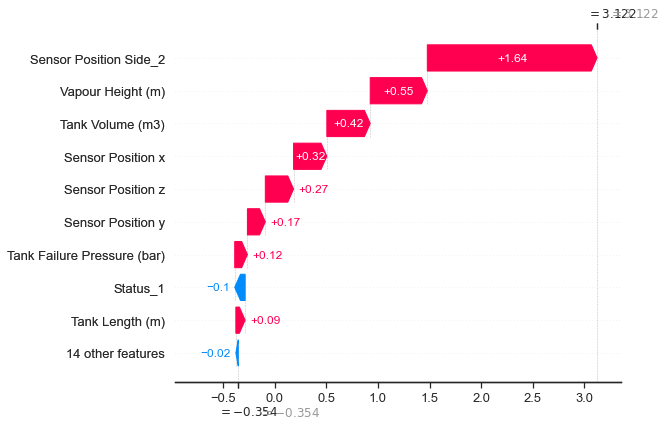

In [62]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[5499], feature_names = X.columns)

In [63]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5499], features = X.columns)

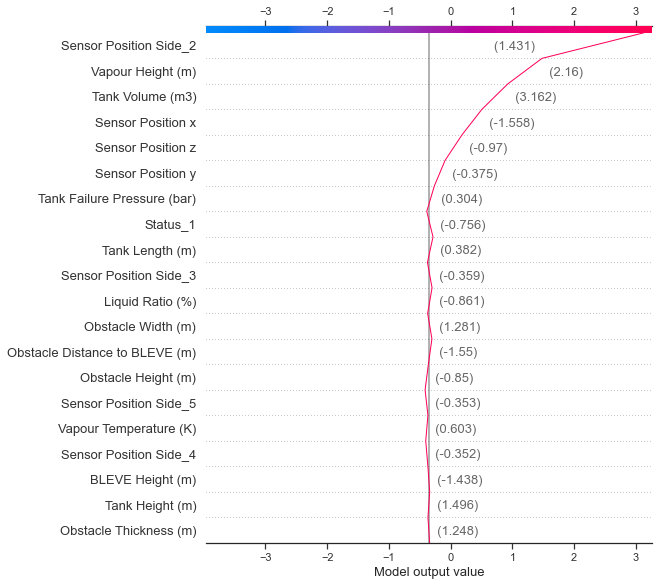

In [64]:
shap.decision_plot(explainer.expected_value, shap_values[5499], 
                   features = X_train[5499], feature_names = X.columns.tolist())

Almost all features which have the most-to-moderate impact on the model contribute positively to this prediction, such as:

+ Sensor Position Side_2   ----  (There is a sensor at this wall side)
+ Vapor Height (m)         ----  (High Vapor Height)
+ Tank Volume (m3)         ---- (High Tank Volume)
+ Sensor Position y        ----  (Moderate coordinate at y-position but positive)
+ Tank Failure Pressure (bar) and so on   ---- (Moderate-to-High Tank Failure Pressure)


There 7 features contributing negatively:
+ Status_1   ---- (Subcooled)
+ Sensor Position Side_3  ---- (No sensor at this wall side)
+ Obstacle Width (m)      ---- (High Obstacle Width)
+ Sensor Position Side_5   ---- (No sensor at this wall side)
+ Sensor Position Side_4    ---- (No sensor at this wall side)
+ BLEVE Height (m)          ---- (Low BLEVE Height)
+ Obstacle Thickness (m)    ---- (High Obstacle Thickness)


Except for Sensor Position Side_3 and 5 which have high impact shown in the summary plot, the other 5 are from moderate to insignificant.

In [65]:
# instance id to be explained
i = 5499
# LIME API works with numpy array
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Target Pressure (bar)'], verbose=True, mode='regression', kernel_width=0.75*len(X.columns), random_state=42)

exp = lime_explainer.explain_instance(X_train[i], BleveNet.predict, num_features=15)

exp.show_in_notebook(show_table=True)

Intercept 1.4433359063700255
Prediction_local [2.28862053]
Right: 3.1212327192833302


Although the Prediction_local is not close to the actual prediction (3.12123), Lime still does a very good job in explaining why this data point is the maximum:

+ Lime says that significant features such as Sensor Position Side_2, Vapour Height, Tank Failure Pressure, etc. contribute positively to this prediction.

+ Lime has 5 features contributing positively to this prediction. However, similar to Shap, apart from Sensor Position Side_3 and 5, which have high impact, the others are mostly insignificant.

# Highest Absolute Percentage Error

In [66]:
def absolute_percentage_error(y, y_hat):
  error =  abs((y-y_hat)/y)
  return error

In [67]:
y_train

4901    0.037163
4375    0.117857
6698    0.136448
9805    0.255415
1101    0.527527
          ...   
5734    0.232742
5191    0.242554
5390    0.059713
860     1.018059
7270    0.109287
Name: Target Pressure (bar), Length: 7500, dtype: float64

In [68]:
APE_scores = np.array([])
for i in range(len(y_predTrain)):
  score = absolute_percentage_error(y_train.values[i], y_predTrain.flatten()[i])
  APE_scores = np.append(APE_scores, score)
APE_scores

array([0.02934029, 0.01749809, 0.03170015, ..., 0.05876082, 0.05925757,
       0.04996596])

In [69]:
np.argmax(APE_scores), APE_scores.max()

(4508, 0.23922260211899887)

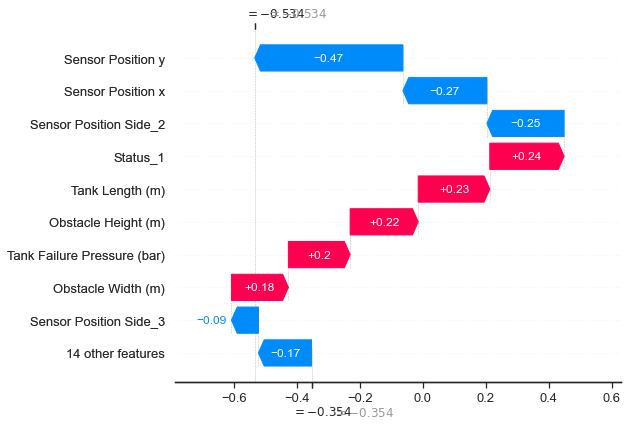

In [70]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[4508], feature_names = X.columns)

In [71]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4508], features = X.columns)

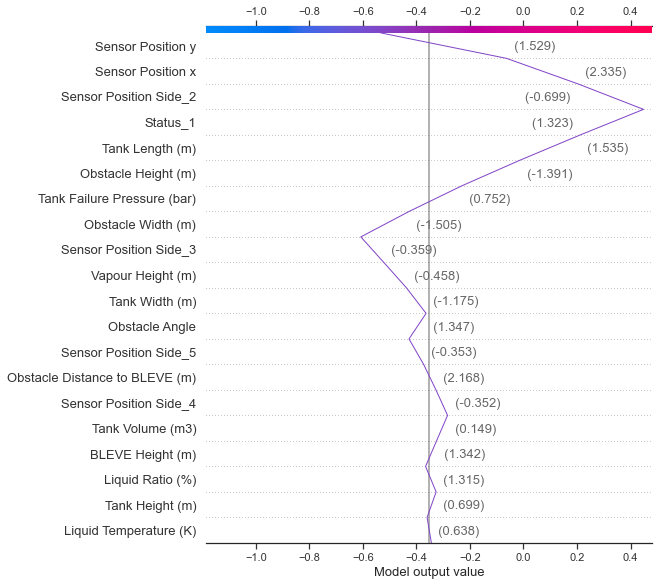

In [72]:
shap.decision_plot(explainer.expected_value, shap_values[4508], 
                   features = X_train[4508], feature_names = X.columns.tolist())

Unlike the highest and lowest prediction where the almost all significant features contribute either positively or negatively accordingly, this prediction has a conflict between contributions of high-impact features.

**Negative** contribution:
+ Sensor Position y        ---  (Moderate (middle) coordinate at y-position)  
+ Sensor Position Side_2   ---  (No sensor at this wall side)
+ Sensor Position Side_3   ---  (No sensor at this wall side)
+ Vapour Height (m)        ---  (Moderate (middle) Vapour Height)

**Positive** contribution:
+ Status_1                  ----  (Superheated)
+ Tank Length               ----  (High Tank Length)
+ Tank Failure Pressure (bar)    ---- (High Tank Failure Pressure)


Obstacle Width, Obstacle Height and Sensor Position x have moderate-to-low impact as indicated in the summary plot. However, for this prediction, they have extremely high contributions and higher than those such as SensorPosition Side_3, Vapour Height and Tank Failure Pressure.

Vapour Height  is the fourth significant impact in the summary plot but it does not contribute much to this prediction.

Major features such as Sensor Position y and Vapour Height have moderate (middle) feature value which may cause confusion for the model (ANN).

ALL above factors could be the cause of highest absolute percentage error.
